In [1]:
from canonymous.canonicalization import (graph_from_molfile,
                                         sort_molecule_by_attribute,
                                         partition_molecule_by_attribute,
                                         partition_molecule_recursively,
                                         assign_canonical_labels)
from canonymous.visualization import print_molecule, draw_molecules
import networkx as nx

MOLFILEPATH = "tests/testfiles"

# Canonicalization

## Molecule partitioning
The goal is to divide atoms in equivalence-classes / partitions.

First, sort the atoms by a fingerprint that consists of the atomic number and the atom's ring neighbors (elaborate).

initial
╒═════════╤═══════════════╤═════════════╤═════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                           │
╞═════════╪═══════════════╪═════════════╪═════════════════════════════════════════════════════════════════════╡
│       0 │ 6543210-1     │           0 │ [(1, '6543210-1', 0), (5, '6543210-1', 0), (11, '1-1', 0)]          │
├─────────┼───────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│       1 │ 6543210-1     │           0 │ [(0, '6543210-1', 0), (2, '6543210-1', 0), (12, '1-1', 0)]          │
├─────────┼───────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│       2 │ 6543210-1     │           0 │ [(1, '6543210-1', 0), (3, '69876543210-1', 0), (13, '1-1', 0)]      │
├─────────┼───────────────┼─────────────┼───────────────────────────────────────────────────────

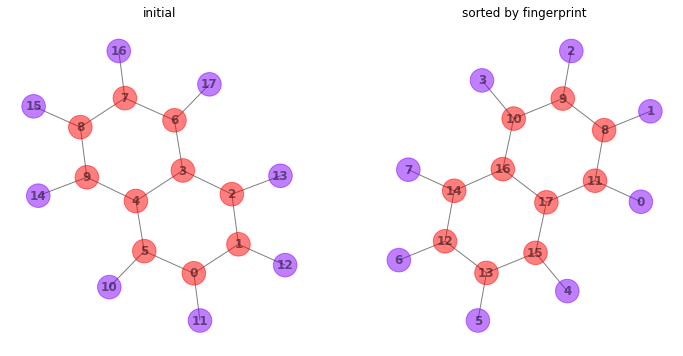

In [2]:
molecule = "naphthalene"
m = graph_from_molfile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol")
m_sorted_by_fingerprint = sort_molecule_by_attribute(m, "fingerprint")
print_molecule(m, "initial")
print_molecule(m_sorted_by_fingerprint, "sorted by fingerprint")
draw_molecules([m, m_sorted_by_fingerprint], ["initial", "sorted by fingerprint"], highlight="atomic_number")

Subsequently, the molecule is partitioned by fingerprint. Elaborate.


╒═════════╤═══════════════╤═════════════╤════════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                              │
╞═════════╪═══════════════╪═════════════╪════════════════════════════════════════════════════════════════════════╡
│       0 │ 1-1           │           0 │ [(11, '6543210-1', 3)]                                                 │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       1 │ 1-1           │           0 │ [(8, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       2 │ 1-1           │           0 │ [(9, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼──────────────────────────────────────

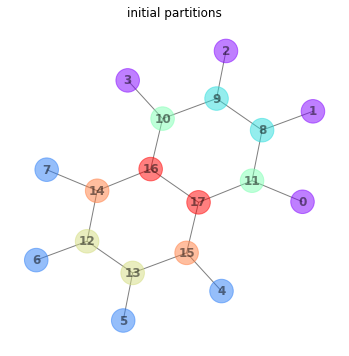

In [3]:
m_partitioned_by_fingerprint = partition_molecule_by_attribute(m_sorted_by_fingerprint, "fingerprint")
print_molecule(m_partitioned_by_fingerprint)
draw_molecules([m_partitioned_by_fingerprint], ["initial partitions"], highlight="partition")

Now, we refine the partitions recursively ("partitioning by partition"). Elaborate.

refined partitions
╒═════════╤═══════════════╤═════════════╤════════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                              │
╞═════════╪═══════════════╪═════════════╪════════════════════════════════════════════════════════════════════════╡
│       0 │ 1-1           │           0 │ [(8, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       1 │ 1-1           │           0 │ [(9, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       2 │ 1-1           │           0 │ [(11, '6543210-1', 3)]                                                 │
├─────────┼───────────────┼─────────────┼────────────────────

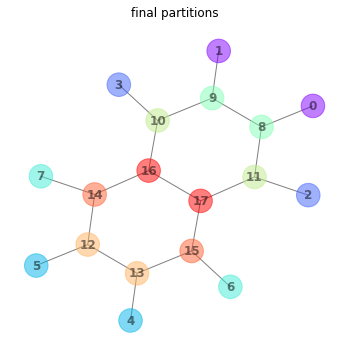

In [4]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_fingerprint, show_steps=True)
draw_molecules([m_partitioned], ["final partitions"], highlight="partition")

After the recursive refinement of the partitions, many partitions contain only a few molecules. This brings us closer to the ultimate goal of the canonicalization. That is, we are closer to shattering the molecule such that each atom resides in a unique partition. How do we shatter the molecule?

## Molecule traversal

Traversing molecule deterministically by branching in a principled way based on partitions.
I.e., establish branching-priorities for situations when traversal can branch to multiple neighbors from atom A:
1. neighbor with larger partition than A
2. neighbor with smaller partition than A
3. neighbor in same partition as A

During traversal, swap indices such that the current molecule A from partition P gets assigned the smallest-available index that remains in partition P. Elaborate.

Current atom index: 0.	Re-labeling to 0.
Current atom index: 8.	Re-labeling to 8.
Current atom index: 11.	Re-labeling to 10.
Current atom index: 9.	Re-labeling to 9.
Current atom index: 17.	Re-labeling to 16.
Current atom index: 2.	Re-labeling to 2.
Current atom index: 10.	Re-labeling to 11.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 15.	Re-labeling to 14.
Current atom index: 16.	Re-labeling to 17.
Current atom index: 3.	Re-labeling to 3.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 13.	Re-labeling to 12.
Current atom index: 14.	Re-labeling to 15.
Current atom index: 4.	Re-labeling to 4.
Current atom index: 12.	Re-labeling to 13.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 5.	Re-labeling to 5.


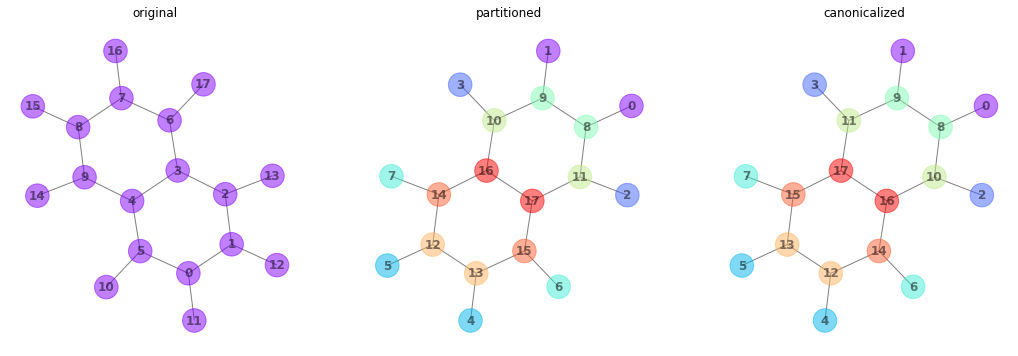

In [5]:
canonical_idcs = assign_canonical_labels(m_partitioned, 0, show_traversal_order=True)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)

draw_molecules([m, m_partitioned, m_canonicalized], ["original", "partitioned", "canonicalized"], highlight="partition")